Now that we know how to manipulate the data, it's time to fit it and extract some model parameters.
First, we will fit to a hand-written function of the excitations

Interface opened
All features have moved to hor_config
> In herbert_config (line 3)Warning: Cannot find test path, possible failed setup
!==================================================================!
!          ISIS utilities for visualization and analysis           !
!                   of neutron spectroscopy data                   !
!                          Herbert 4.0.0                           !
!------------------------------------------------------------------!
All features have moved to hor_config
!==================================================================!
!                           Horace 4.0.0                           !
!------------------------------------------------------------------!
!   Visualisation of multi-dimensional neutron spectroscopy data   !
!                                                                  !
!           R.A. Ewings, A. Buts, M.D. Le, J van Duijn,            !
!                  I. Bustinduy, and T.G. Perring                 

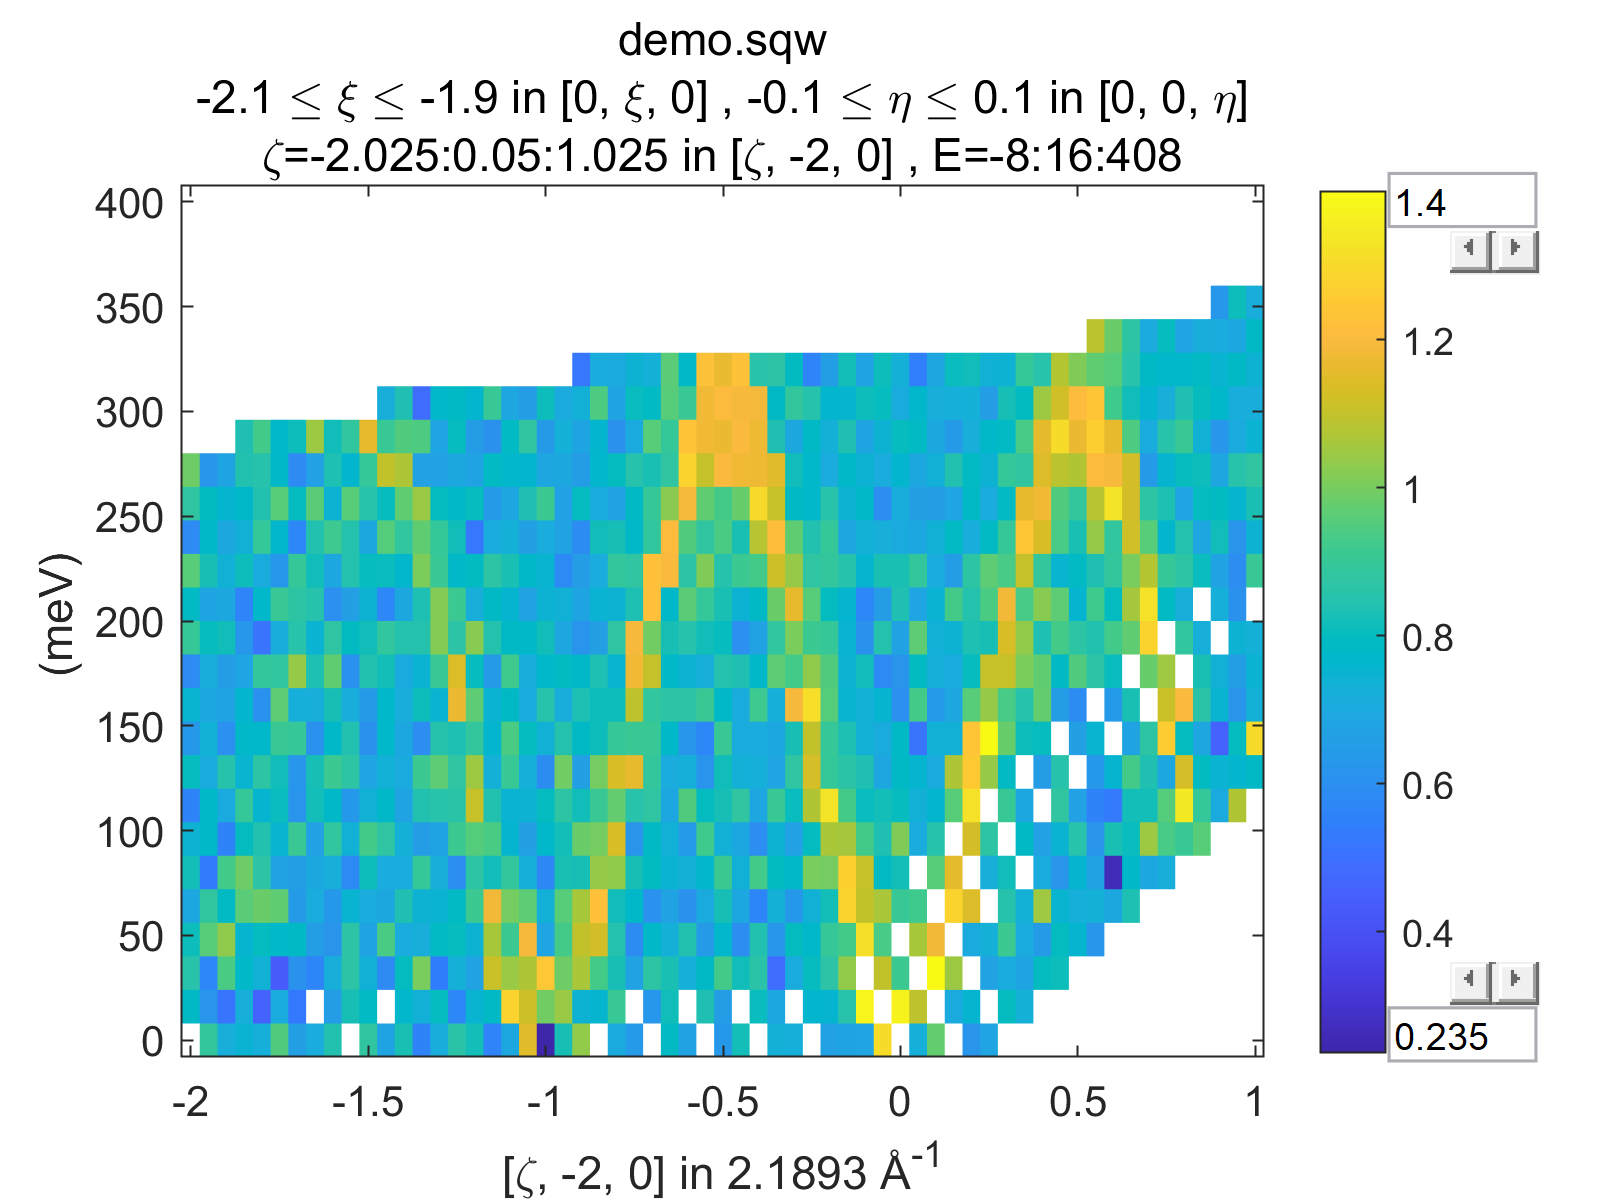

In [1]:
from pace_neutrons import Matlab
m = Matlab() 

sqw_file = 'demo.sqw'
proj = {
    'u': [1, 0, 0],
    'v': [0, 1, 0],
    'type': 'rrr'
}

%matlab_plot_mode inline inline
%matlab_fig -w 1600 -h 1200 
# 2D slice
cc2 = m.cut_sqw(sqw_file, proj, [-2, 0.05, 1], [-2-0.1, -2+0.1], [-0.1, 0.1], [0, 16, 400])
m.plot(cc2)


To fit the data, we need to define a model. This is most easily done in Python. Below, we define a model of spin waves, which is identical to the one used to generate the data. 

In [3]:
import numpy as np
def fm_sqw(h, k, l, e, p):
    """
    Compute the dynamic structure factor S(Q, ω) for Fe using a Damped Harmonic Oscillator (DHO) model.

    Parameters
    ----------
    h, k, l : float or array-like
        Miller indices components.
    e : float or array-like
        Energy transfer (meV).
    p : list or array-like
        Model parameters:
        p[0] = J      (exchange constant)
        p[1] = Delta  (spin gap)
        p[2] = Gamma  (damping)
        p[3] = T      (temperature in K)
        p[4] = scale  (intensity scale factor)

    Returns
    -------
    S : float or array-like
        The scattering function S(Q, ω).
    """
    # Unpack parameters
    J, Delta, Gamma, T, scale = p

    # DHO dispersion relation
    omega = Delta + 4 * J * (
        np.sin(np.pi * h)**2 + 
        np.sin(np.pi * k)**2 + 
        np.sin(np.pi * l)**2
    )

    # Form factor parameters (Fe)
    A, a = 0.0706, 35.008
    B, b = 0.3589, 15.358
    C, c = 0.5819, 5.561
    D = -0.0114

    # Q squared
    q_squared = ((1 / (2 * 2.87))**2) * (h**2 + k**2 + l**2)

    # Magnetic form factor
    ff = A * np.exp(-a * q_squared) + \
         B * np.exp(-b * q_squared) + \
         C * np.exp(-c * q_squared) + D

    # Bose factor (detailed balance)
    bose = e / (1 - np.exp(-11.602 * e / T))

    # Damped Harmonic Oscillator model
    numerator = 4 * Gamma * omega
    denominator = (e**2 - omega**2)**2 + 4 * (Gamma * e)**2
    dho = numerator / denominator

    return scale * (ff**2) * (1 / np.pi) * bose * dho

In [30]:
sqw_file = 'demo.sqw'

# Make a series of 1D cuts of the data
proj = {'u':[1,0,0], 'v':[0,1,0], 'type':'rrr'}
energy_range = range(20, 160, 20)
my_cuts = []

# Evaluating sqw_eval for a list of cuts doesn't work at the moment
for i in range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.025,3], [-1.05,-0.95], [-0.1,0.1], [-10+energy_range[i], 10+energy_range[i]]));

energy_range = range(160, 320, 20)
# Evaluating sqw_eval for a list of cuts doesn't work at the moment
for i in range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-2.1,-1.9], [-0.1,0.1], [-10+energy_range[i], 10+energy_range[i]]));


*** Step 1 of 1; Read data for     9632 pixels -- processing data... ----->  retained      1744 pixels
*** Step 1 of 1; Read data for    10308 pixels -- processing data... ----->  retained      1255 pixels
*** Step 1 of 1; Read data for    11131 pixels -- processing data... ----->  retained      2057 pixels
*** Step 1 of 1; Read data for    12133 pixels -- processing data... ----->  retained      1499 pixels
*** Step 1 of 1; Read data for    21316 pixels -- processing data... ----->  retained      2541 pixels
*** Step 1 of 1; Read data for    21183 pixels -- processing data... ----->  retained      1932 pixels
*** Step 1 of 1; Read data for    22083 pixels -- processing data... ----->  retained      3493 pixels
*** Step 1 of 1; Read data for     9594 pixels -- processing data...*** Step 1 of 1; Read data for    10373 pixels -- processing data... ----->  retained      3717 pixels
*** Step 1 of 1; Read data for    17913 pixels -- processing data... ----->  retained      2706 pixels
*** S

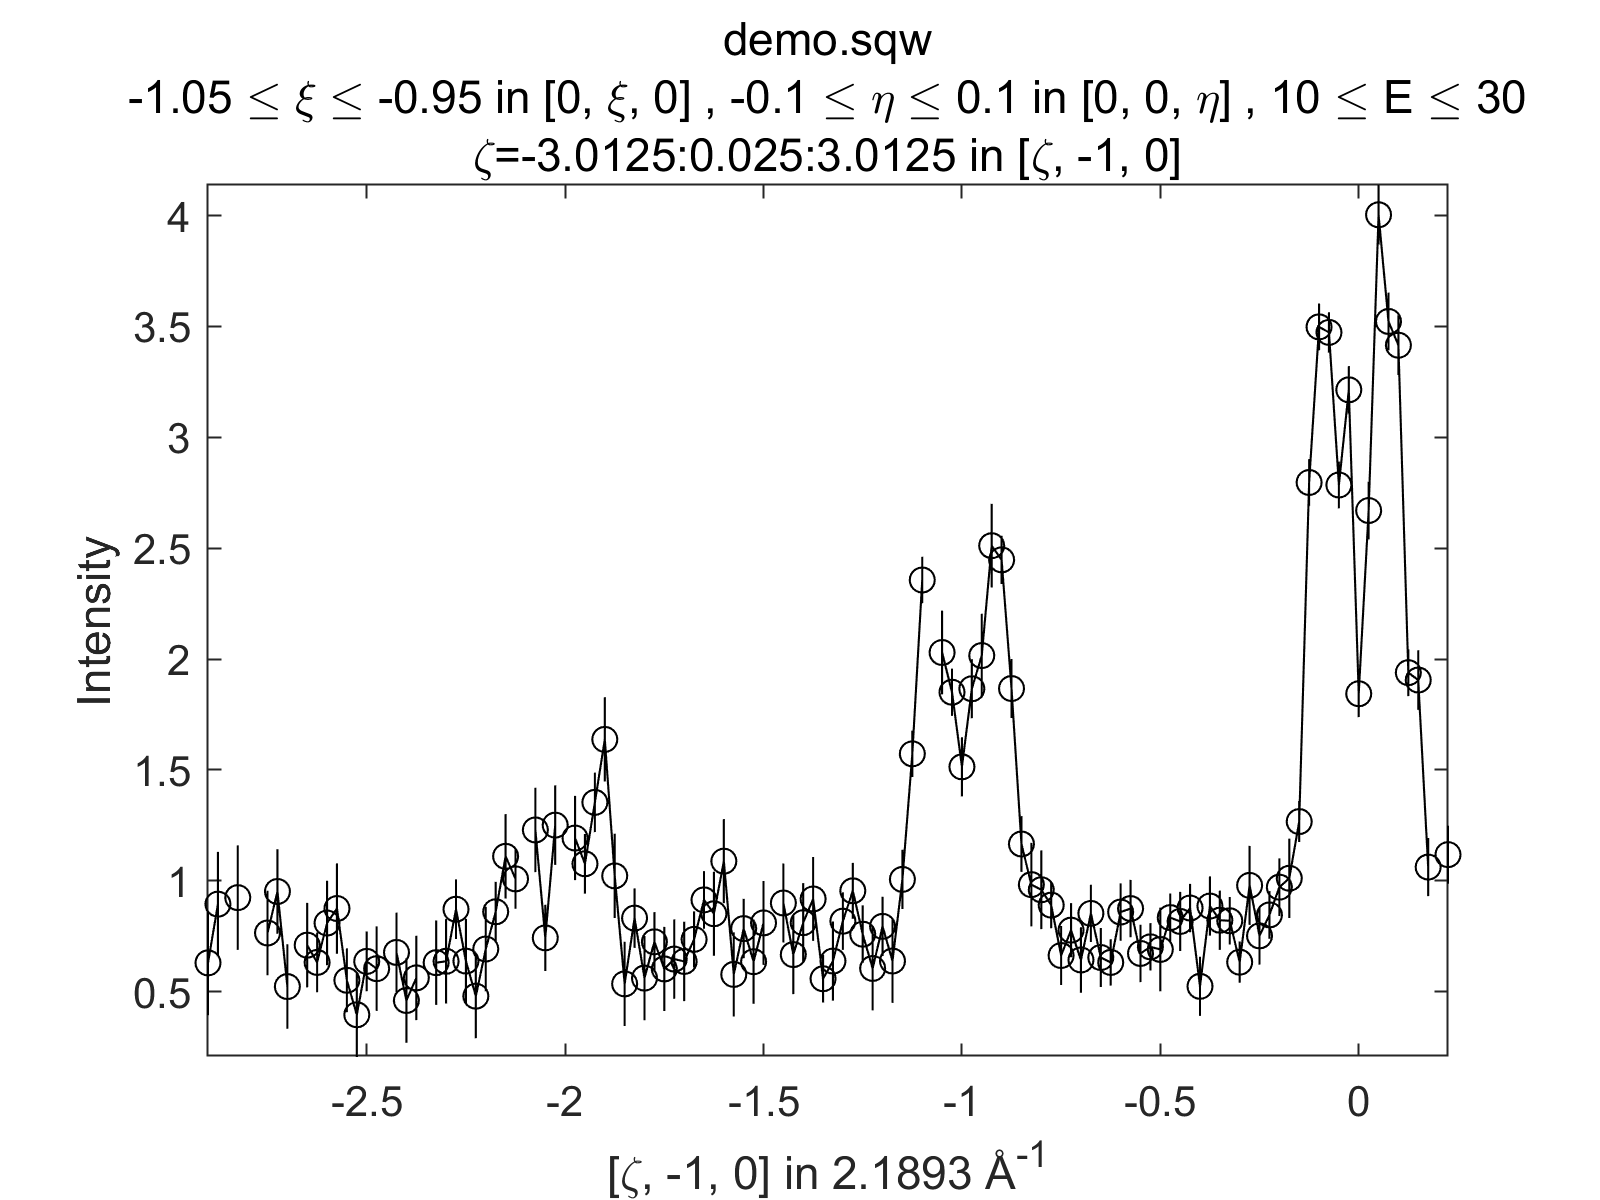

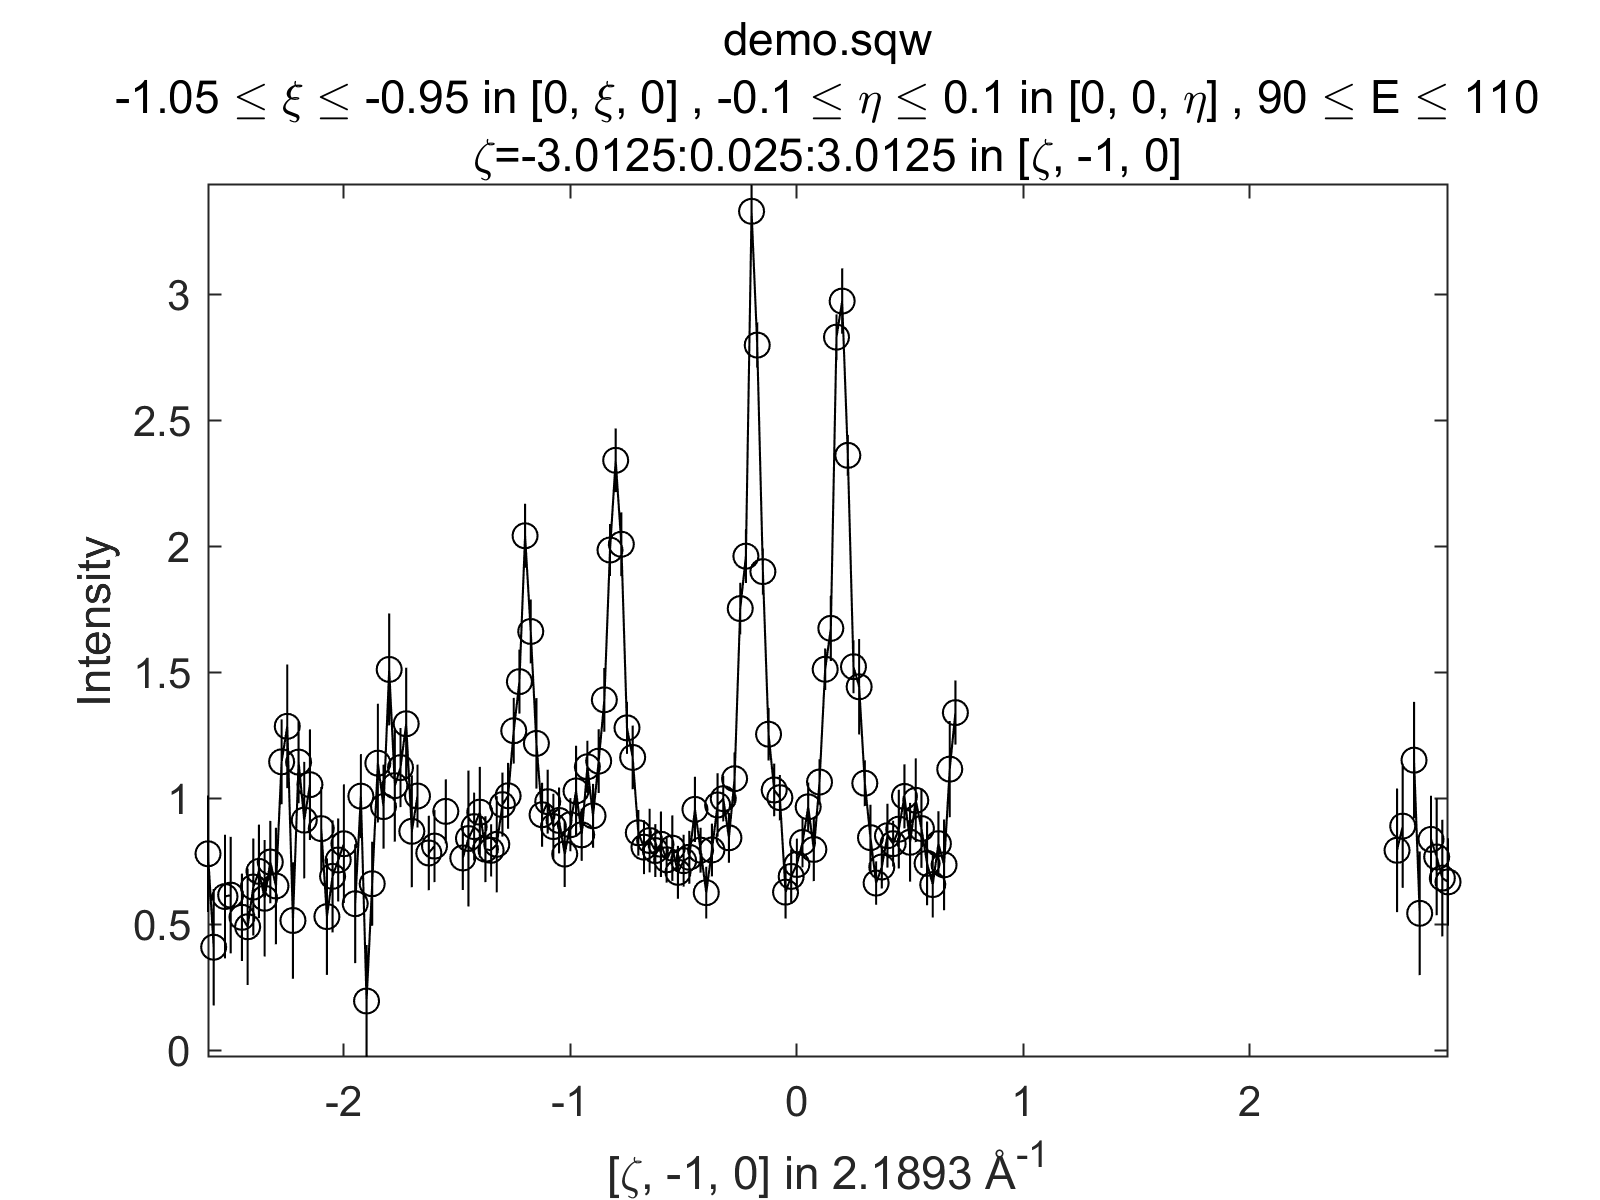

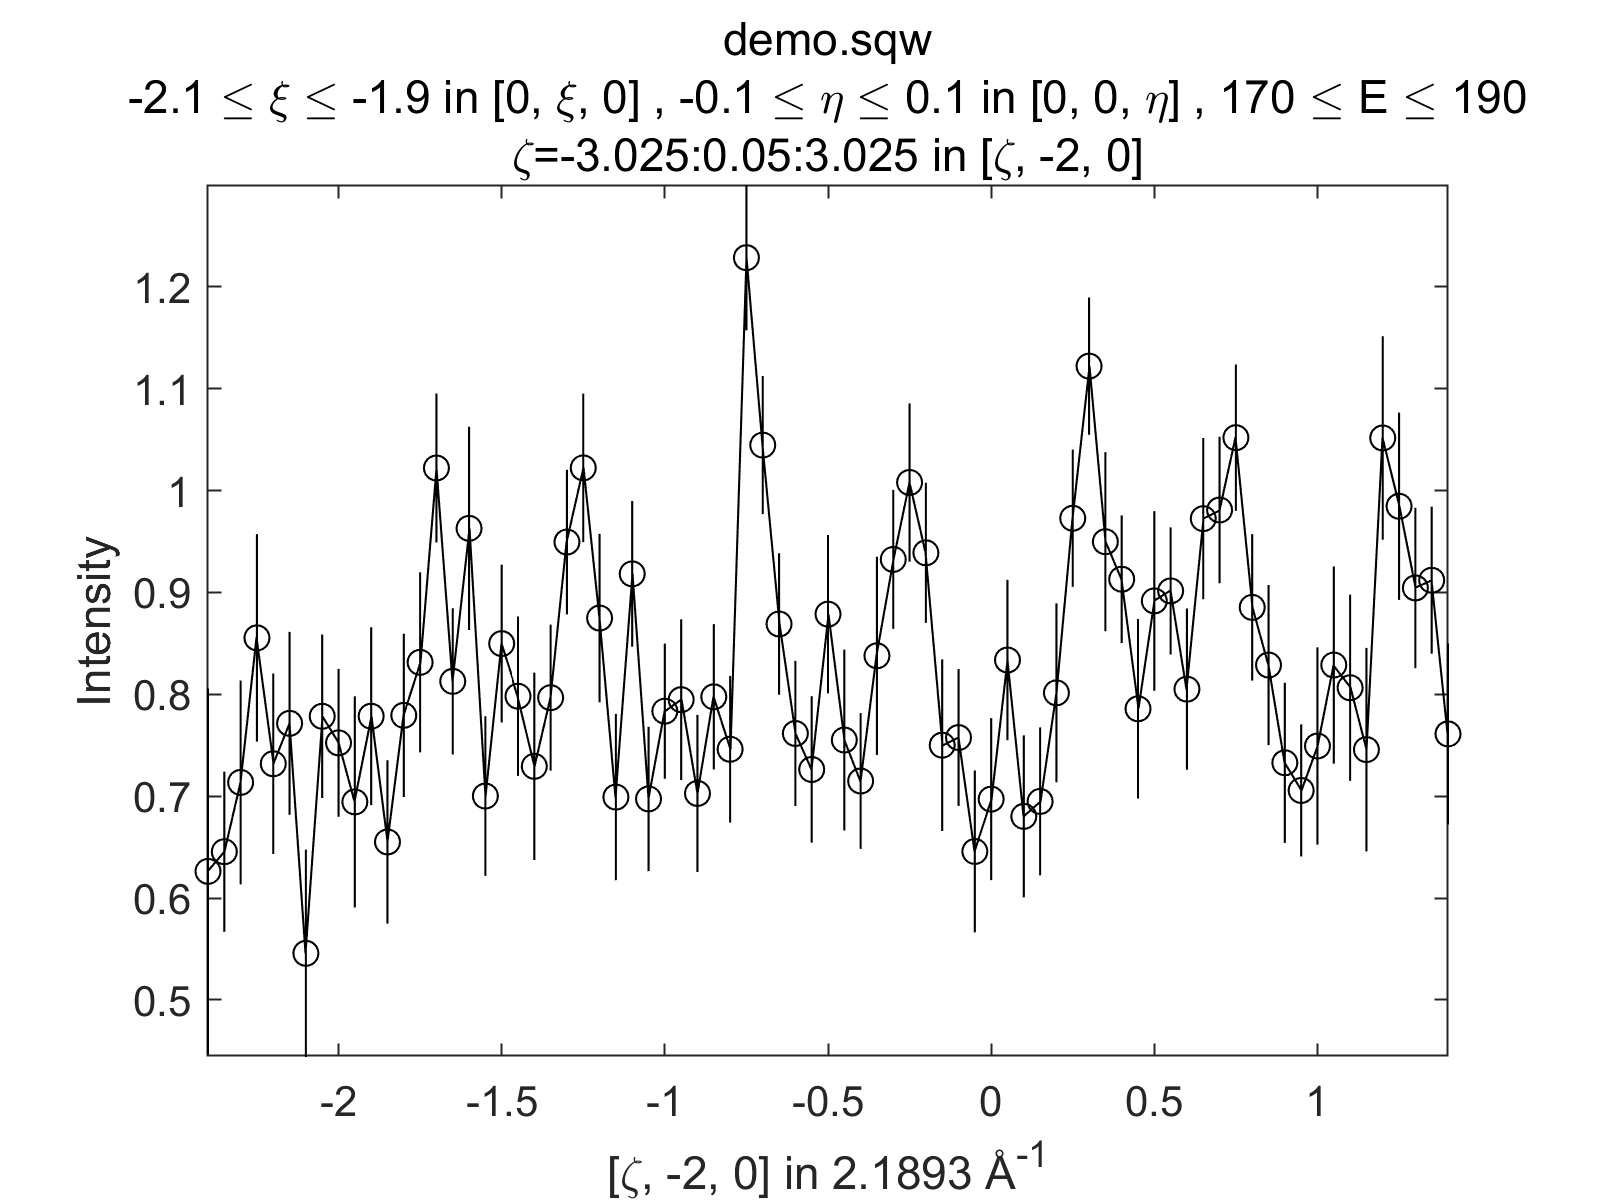

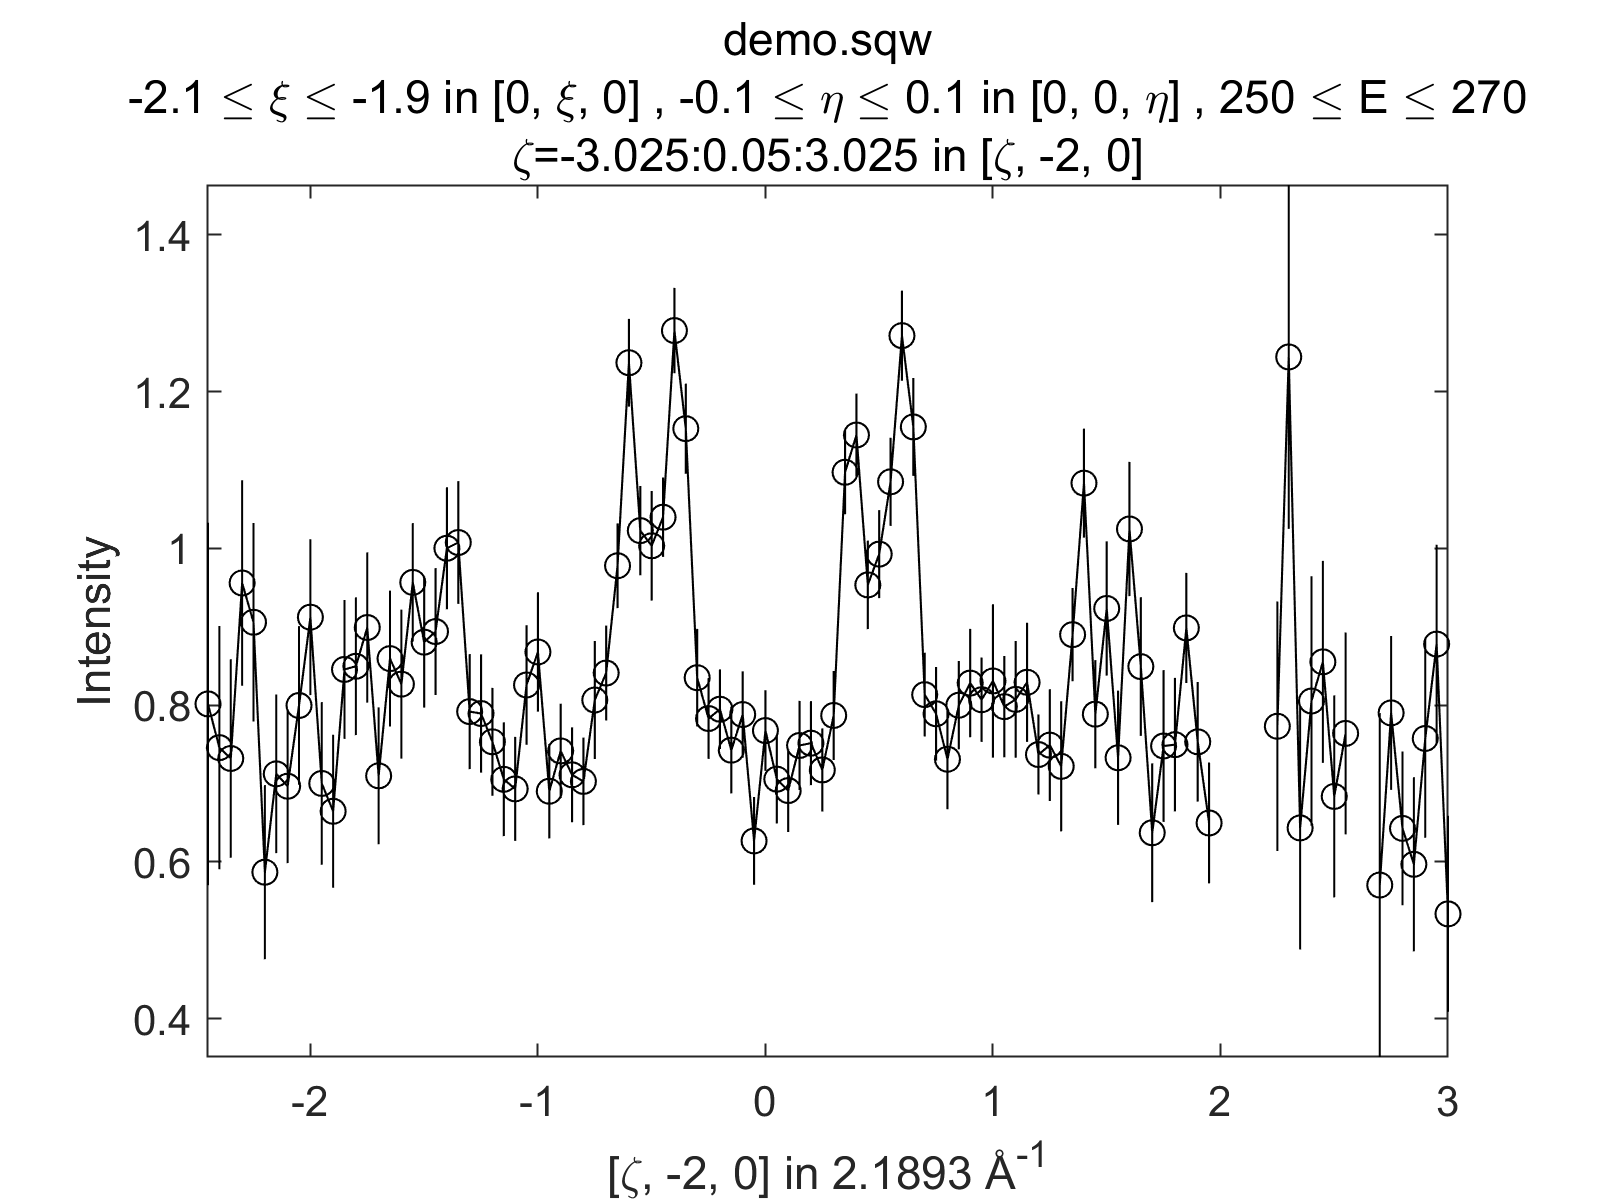

In [32]:
%matlab_fig -w 1600 -h 1200 
for i in range(len(my_cuts)):
    if np.mod(i, 4) == 0:
        m.dd(my_cuts[i])
        m.keep_figure()



In [ ]:

##
# Run the fitting with an analytical expression for the cross-section
#  - using an exact expression for the dispersion of a body-centered cubic 
#    FM combined with a damped harmonic oscillator for the intensity.
# The parameters of the function is: [JS Delta Gamma Temperature Amplitude]
p0 = [35, 0, 30, 10, 300];
# Expression for the dispersion
om = m.eval('@(h,k,l,e,js,d) d + (8*js)*(1-cos(pi*h).*cos(pi*k).*cos(pi*l))');

In [ ]:
# The magnetic form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114;
ff = m.eval('@(h,k,l) sum(bsxfun(@times, [{} {} {}], exp(bsxfun(@times, -[{} {} {}], ((1/(2*2.87)).^2 .* (h(:).^2 + k(:).^2 + l(:).^2))))), 2) + {}'.format(A, B, C, a, b, c, D));
# Put it altogether
m.assignin('base', 'om', om)
m.assignin('base', 'ff', ff)
fe_sqw = m.evalin('base', '@(h,k,l,e,p) ff(h,k,l).^2 .* (p(5)/pi) .* (e./(1-exp(-11.602.*e./p(4)))) .* 4.*p(3).*om(h,k,l,e,p(1),p(2)) ./ ((e.^2-om(h,k,l,e,p(1),p(2)).^2).^2 + 4.*(p(3).*e).^2)');
linear_bg = m.eval('@linear_bg');

# Starting parameters for fit
J = 35;
D_A = 0;
gam = 30;
temp = 10;
amp = 300;

# Define the equivalent Python function
def py_fe_sqw(h, k, l, e, p):
    js = p[0]
    d = p[1]
    om = d + (8*js) * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
    return (ff**2) * (p[4]/np.pi) * (e / (1-np.exp(-11.602*e/p[3]))) * (4 * p[2] * om) / ((e**2 - om**2)**2 + 4*(p[2] * e)**2)

fe_sqw

In [ ]:
p=[35, 0, 30, 10, 300]
zeta=0.1
h=1+zeta
k=-1+zeta
l=0
e=100

py_test_result=py_fe_sqw(h, k, l, e, p)
print(py_test_result)

m_test_result=fe_sqw(h, k, l, e, p)
print(m_test_result)


In [ ]:

def ff_py(h,k,l):
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    return A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D

print(ff(h,k,l))
print(ff_py(h,k,l))

In [ ]:

# Call with Matlab function
w_cal_m = m.sqw_eval(my_cuts[0], fe_sqw, [35, 0, 30, 10, 300])


In [ ]:

# Call with Python function
w_cal_py = m.sqw_eval(my_cuts[0], py_fe_sqw, [35, 0, 30, 10, 300])


In [ ]:

w_sum_m = m.cut(w_cal_m, [-999., 999.])
print("Summed counts in Matlab calculated cuts = {}".format(w_sum_m.data.s))
w_sum_py = m.cut(w_cal_py, [-999., 999.])
print("Summed counts in Python calculated cuts = {}".format(w_sum_py.data.s))


%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 

hf1 = m.plot(w_cal_m)


In [ ]:
%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 
hf2=m.plot(w_cal_py)

In [ ]:
%matlab_plot_mode inline
%matlab_fig -w 1200 -h 800 
hf2=m.plot(w_cal_py/w_cal_m)
# m.uiwait(hf1)


In [ ]:

kk = m.multifit_sqw(my_cuts[0])
kk = kk.set_fun (fe_sqw, [J, D_A, gam, temp, amp])
kk = kk.set_free ([1, 0, 1, 0, 1])
kk = kk.set_bfun (linear_bg, [0.1,0])
kk = kk.set_bfree ([1,0])
kk = kk.set_options ('list',2)

# Time it to see how long it takes to do the fit
m.tic()
wfit, fitdata = kk.fit('comp')
t_ana = m.toc()
print(t_ana)

In [ ]:
m.pl(wfit['sum'])

In [ ]:
#
# testing the lswt algorithm (https://arxiv.org/abs/1402.6069) directly for comparison,
# both for a 1d ferromagnetic and for an antiferromagnetic chain
# @author Tobias Weber <tweber@ill.fr>
# @date 24-oct-2024
# @license GPLv3, see 'LICENSE' file
#

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


is_ferromagnetic = False  # choose ferromagnetic or antiferromagnetic 1d spin chain
only_pos_E = False        # hide magnon annihilation?


#
# magnetic sites
# "S": spin magnitude
# "Sdir": spin direction
#
if is_ferromagnetic:
	sites = [
		{ "S" : 1., "Sdir" : [ 0, 0, 1 ] },
	]
else:  # antiferromagnetic
	sites = [
		{ "S" : 1., "Sdir" : [ 0, 0, 1 ] },
		{ "S" : 1., "Sdir" : [ 0, 0, -1 ] },
	]

#
# magnetic couplings
# "sites": indices of the sites to couple
# "J": (symmetric) exchange interaction
# "DMI": (antisymmetric) Dzyaloshinskii-Moryia interaction
# "dist": distance in rlu to the next unit cell for the coupling
#
if is_ferromagnetic:
	couplings = [
		{ "sites" : [ 0, 0 ], "J" : -1., "DMI" : [ 0, 0, 0 ], "dist" : [ 1, 0, 0 ] },
	]
else:  # antiferromagnetic
	couplings = [
		{ "sites" : [ 0, 1 ], "J" : 1., "DMI" : [ 0, 0, 0 ], "dist" : [ 0, 0, 0 ] },
		{ "sites" : [ 1, 0 ], "J" : 1., "DMI" : [ 0, 0, 0 ], "dist" : [ 2, 0, 0 ] },
	]


# skew-symmetric (cross-product) matrix
def skew(vec):
	return np.array([
		[      0.,   vec[2],  -vec[1] ],
		[ -vec[2],       0.,   vec[0] ],
		[  vec[1],  -vec[0],       0. ] ])


# calculate spin rotations towards ferromagnetic order along [001]
for site in sites:
	zdir = np.array([ 0., 0., 1. ])
	Sdir = np.array(site["Sdir"]) / la.norm(site["Sdir"])
	rotaxis = np.array([ 0., 1., 0. ])
	s = 0.

	if np.allclose(Sdir, zdir):
		# spin and z axis parallel
		c = 1.
	elif np.allclose(Sdir, -zdir):
		# spin and z axis anti-parallel
		c = -1.
	else:
		# sine and cosine of the angle between spin and z axis
		rotaxis = np.cross(Sdir, zdir)
		s = la.norm(rotaxis)
		c = np.dot(Sdir, zdir)
		rotaxis /= s

	# rotation via rodrigues' formula, see (Arens 2015), p. 718 and p. 816
	rot = (1. - c) * np.outer(rotaxis, rotaxis) + np.diag([ c, c, c ]) - skew(rotaxis)*s
	site["u"] = rot[0, :] + 1j * rot[1, :]
	site["v"] = rot[2, :]

	#print(np.dot(rot, Sdir))
	#print("\nrot = \n%s\nu = %s\nv = %s" % (rot, site["u"], site["v"]))



# calculate real interaction matrices
for coupling in couplings:
	J = coupling["J"]
	coupling["J_real"] = np.diag([ J, J, J ]) + skew(coupling["DMI"])

	#print("\nJ_real =\n%s" % coupling["J_real"])


# get the energies of the dispersion at the momentum transfer Qvec
def get_energies(Qvec):
	#print("\n\nQ = %s" % Qvec)

	# fourier transform interaction matrices
	num_sites = len(sites)
	J_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)
	J0_fourier = np.zeros((num_sites, num_sites, 3, 3), dtype = complex)

	for coupling in couplings:
		dist = np.array(coupling["dist"])
		J_real = coupling["J_real"]
		site1 = coupling["sites"][0]
		site2 = coupling["sites"][1]

		J_ft = J_real * np.exp(-1j * 2.*np.pi * np.dot(dist, Qvec))
		J_fourier[site1, site2] += J_ft
		J_fourier[site2, site1] += J_ft.transpose().conj()
		J0_fourier[site1, site2] += J_real
		J0_fourier[site2, site1] += J_real.transpose().conj()

	#print("\nJ_fourier =\n%s\n\nJ0_fourier =\n%s" % (J_fourier, J0_fourier))


	# hamiltonian
	H = np.zeros((2*num_sites, 2*num_sites), dtype = complex)

	for i in range(num_sites):
		S_i = sites[i]["S"]
		u_i = sites[i]["u"]
		v_i = sites[i]["v"]

		for j in range(num_sites):
			S_j = sites[j]["S"]
			u_j = sites[j]["u"]
			v_j = sites[j]["v"]
			S = 0.5 * np.sqrt(S_i * S_j)

			H[i, j] += S * np.dot(u_i, np.dot(J_fourier[i, j], u_j.conj()))
			H[i, i] -= S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[num_sites + i, num_sites + j] += \
				S * np.dot(u_i.conj(), np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, num_sites + i] -= \
				S_j * np.dot(v_i, np.dot(J0_fourier[i, j], v_j))
			H[i, num_sites + j] += \
				S * np.dot(u_i, np.dot(J_fourier[i, j], u_j))
			H[num_sites + i, j] += \
				(S * np.dot(u_j, np.dot(J_fourier[j, i], u_i))).conj()

	#print("\nH =\n%s" % H)


	# trafo
	C = la.cholesky(H)
	signs = np.diag(np.concatenate((np.repeat(1, num_sites), np.repeat(-1, num_sites))))
	H_trafo = np.dot(C.transpose().conj(), np.dot(signs, C))

	#print("\nC =\n%s\n\nH_trafo =\n%s" % (C, H_trafo))


	# the eigenvalues of H give the energies
	Es = np.real(la.eigvals(H_trafo))
	return Es


# plot a dispersion branch
hs = []
Es = []
for h in np.linspace(-1, 1, 1024):
	try:
		Qvec = np.array([ h, 0, 0 ])
		for E in get_energies(Qvec):
			if only_pos_E and E < 0.:
				continue
			hs.append(h)
			Es.append(E)
	except la.LinAlgError:
		pass

plt.plot()
plt.xlabel("h (rlu)")
plt.ylabel("E (meV)")
plt.scatter(hs, Es, marker = '.')
plt.show()